In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.io
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Fetch image and ground truth

In [2]:
url = 'http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat'
r = urlopen(url)
image = scipy.io.loadmat(BytesIO(r.read()))['indian_pines_corrected']

url_gt = 'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat'
r = urlopen(url_gt)
labels = scipy.io.loadmat(BytesIO(r.read()))['indian_pines_gt']

In [3]:
def get_class_names():
    return ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']


def prediction_probability(model, test, indices, location):
    place = np.where((indices[:,0]==location[0]) & (indices[:,1]==location[1]))
    classes = get_class_names()
    for i in range(len(classes)):
        print(classes[i] + ":" + str("{:.2f}".format(model.predict_proba(test)[place][0][i])))
        
    
def data_prepare(gt, im, samples=None):
    classes=np.unique(gt)
    classes = classes[classes != 0]
    
    data = []
    datalabel = np.array([])
    for i in range(len(classes)):
        indices = np.where(gt == classes[i])
        if samples is not None:
            indices = np.array(indices)
            indices = indices.T
            np.random.shuffle(indices)
            indices = indices.T
            B = np.array(indices)[:, :samples]
            indices = tuple(B)
           
        newdata = im[indices[0], indices[1]]
        data.append(newdata)
        datalabel = np.append(datalabel, np.full((newdata.shape[0]), classes[i], dtype=np.uint8),axis=0)
    return np.uint8(np.vstack(data)), np.uint8(datalabel)


def color_image(im):
    colors = [[0, 0, 0],
             [255, 0, 0],
            [255, 255, 0],
            [128, 0, 0],
            [255, 0, 255],
            [0, 0, 255],
            [0, 255, 255],
            [128, 128, 0],
            [0, 128, 128],
            [0, 64, 255],
            [0, 0, 128],
            [0, 128, 255],
            [255, 0, 128],
            [255, 64, 0],
            [50, 150, 220],
            [180, 90, 0],
            [0, 45, 30]]
    
    new_im = np.zeros([145, 145, 3], dtype=int)
    for i in range(np.max(im)):
        indices_class = np.array(np.where(im == i))
        new_im[indices_class[0, :], indices_class[1, :], :]=colors[i]
    return new_im


def turn_image(vector, gt):
    classes = np.unique(gt)
    classes = classes[classes != 0]
    indices=None
    for i in range(len(classes)):
            newind = np.array(np.where(gt == classes[i]))

            if indices is None:
                indices = newind
            else:
                indices = np.concatenate(([indices, newind]), axis=1)
    indices = np.transpose(indices)
    new_im = np.zeros([145, 145], dtype=int)
    new_im[indices[:, 0], indices[:, 1]] = vector
    return new_im, indices


def RFclassification(train, test, trainlabel, testlabel):
    clf = RandomForestClassifier(n_estimators=300, max_features='sqrt',
	max_depth=25, min_samples_split=2,n_jobs=12)
    clf.fit(train, trainlabel)
    y_pred = clf.predict(test)
    #visualize(y_pred,i,ref)
    print("Overall Accuracy:", str("{:.2f}".format(metrics.accuracy_score(testlabel, y_pred))))
    f1_scores = f1_score(testlabel, y_pred, average=None)
    for i in range(len(f1_scores)):
        print(get_class_names()[i] + ":" + str("{:.2f}".format(f1_scores[i])))
    plot_confusion_matrix(clf, test, test_label)
    return clf, y_pred

This data has 200 features for each pixel.

In [4]:
print(np.shape(image))
print(np.shape(labels))

(145, 145, 200)
(145, 145)


# Visualize one sample channel and ground truth 

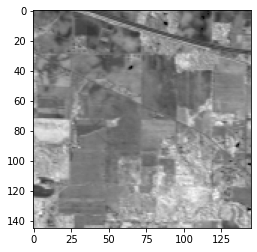

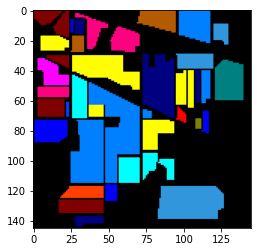

In [5]:
plt.figure()
plt.imshow(image[:, :, 50], cmap='gray')
plt.figure()
plt.imshow(color_image(labels))

In [6]:
test, test_label = data_prepare(labels, image)
train, train_label = data_prepare(labels, image,samples=100)

I removed mislabelled pixels, then created test and training samples from data.

In [7]:
print(np.shape(test))
print(np.shape(test_label))
print(np.shape(train))
print(np.shape(train_label))

(10249, 200)
(10249,)
(1387, 200)
(1387,)


# Display accuracy, f1 scores and confusion matrix

Overall Accuracy: 0.69
Alfalfa:0.88
Corn-notill:0.59
Corn-mintill:0.61
Corn:0.51
Grass-pasture:0.85
Grass-trees:0.88
Grass-pasture-mowed:0.93
Hay-windrowed:0.95
Oats:0.80
Soybean-notill:0.63
Soybean-mintill:0.58
Soybean-clean:0.52
Wheat:0.95
Woods:0.93
Buildings-Grass-Trees-Drives:0.60
Stone-Steel-Towers:0.69


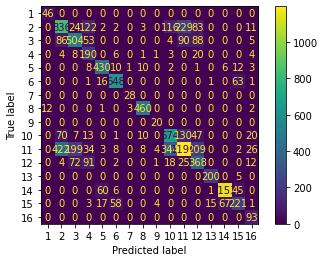

In [8]:
model, y_pred = RFclassification(train, test, train_label, test_label)

# Visualize results

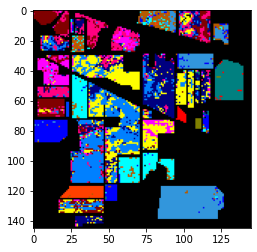

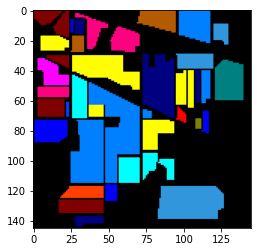

In [9]:
predicted_image, indices = turn_image(y_pred, labels)
plt.figure()
plt.imshow(color_image(predicted_image))
plt.figure()
plt.imshow(color_image(labels))

# Region of Interest

It would be interesting to choose region of interest to look close. Here I will do it manually but in inspector it could be with mouse.

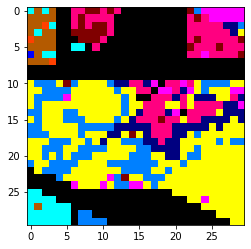

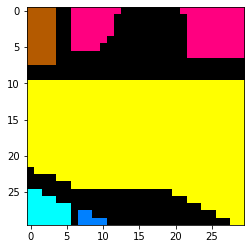

In [10]:
plt.figure()
plt.imshow(color_image(predicted_image)[20:50, 30:60])
plt.figure()
plt.imshow(color_image(labels)[20:50, 30:60])

# Prediction probability for selected location

One may click a pixel to see prediction probability of this location. It is possible to use following ginput command. However, it is not possible in notebook. Therefore, I will select manual location for now.

In [11]:
# from pylab import ginput
# y,x=ginput(1)[0]

In [12]:
location = [20, 30]
prediction_probability(model, test, indices, location)

Alfalfa:0.00
Corn-notill:0.00
Corn-mintill:0.00
Corn:0.02
Grass-pasture:0.05
Grass-trees:0.41
Grass-pasture-mowed:0.00
Hay-windrowed:0.00
Oats:0.02
Soybean-notill:0.00
Soybean-mintill:0.00
Soybean-clean:0.00
Wheat:0.18
Woods:0.01
Buildings-Grass-Trees-Drives:0.32
Stone-Steel-Towers:0.00
